# CM3015 FINALS REPORT

## Defining the problem and assembling a dataset

This project involves developing a deep learning model that will be used to predict the likelihood of pneumonia in patients using the Pneumonia_MNIST dataset from Tensorflow. The dataset is publicly available and data collection is not required. The dataset has also been pre-annotated with labels indicating the presence or absence of pneumonia as pneumonia-positive and pneumonia-negative respectively.

The input data that will be used for the model is the grayscaled chest X-ray images from the Pneumonia_MNIST dataset. The output prediction will be a probability score indicating whether a patient has pneumonia or not.

Due to the dataset only having two labels (pneumonia-positive and pneumonia-negative) it is a binary classification problem. Therefore, the model will function by categorising the input images to either pneumonia-positive (class 1) and pneumonia-negative (class 0). A classification-based neural network architecture will be used for this model, and the loss function used will be binary cross-entropy.

Some hypothesis that are made would be that the presence of pneumonia can be determined solely from chest X-ray images and that the dataset provides sufficient distinguishing features for a deep learning model to be able to differentiate between healthy and pneumonia-affected lungs.



## Choosing a measure of success

The Pneumonia_MNIST dataset is highly class-imbalanced, with pneumonia-negative being about 70% and pneumonia-positive being about 30%, hence, relying solely on accuracy could lead to unaccurate results.
Instead, a combination of metrics such as precision, recall, F1-score, and AUC-PR (area under the precision-recall curve), along with the confusion matrix will be used to measure the level of success.

The precision metric measures the proportion of correctly predicted pneumonia cases out of all cases predicted as pneumonia, helping to assess the model’s ability to avoid false positives. The recall metric  measures the proportion of actual pneumonia cases that were correctly identified, helping to check if there is a high number of false negatives. The F1-Score measures the mean of precision and recall, and provides a balance between the two. The AUC-PR focuses on the performance of the model on the positive class and is more sensitive to changes in precision and recall than AUC-ROC for inbalanced class datasets. The confusion matrix will provide a breakdown of true positives, false positives, true negatives, and false negatives, allowing for an in-depth understanding of the model’s misclassifications.

The desired results for the metrics would be a high precision and high recall, and low false negatives and low false positives

## Deciding on an evaluation protocol

As the Pneumonia_MNIST dataset is class-imbalanced, just using a simple holdout validation may not accurately depict the performance of the model. Therefore, stratified K-fold cross-validation will be used as well, as it provides a more balanced representation by ensuring that each fold maintains the same proportion of pneumonia-positive and pneumonia-negative cases. Stratified K-fold cross-validation also reduces the risk of misleading results by splitting the dataset into multiple training and validation sets, reducing the risk of misleading results.

In this model, 5 folds will be used and in each iteration, the model will be trained on (K-1)/K of the data and validated on the remaining 1/K. The precision, recall, F1-score, AUC-PR, and the confusion matrix will be used and averaged across all folds to obtain a more accurate evaluation.

After carrying out stratified K-fold cross-validation, holdout validation will be carried out on the chosen best model to help evaluate the chosen model on a set of data that is completely independent of the training and cross-validation processes. This ensures a more accurate estimate of how the model could perform on completely new data.

## Preparing the dataset

In this section, the Pneumonia_MNIST dataset is preprocessed for model training. The dataset is first loaded in using tensorflow_datasets (tfds), combining both the train and test splits for better control over data partitioning. The images in the dataset are then resized to 16x16 pixels using skimage.transform.resize to reduce computational complexity and are stored in NumPy arrays for easier manipulation. To ensure compatibility with the model, the images in the dataset that are originally 2D matrices are reshaped into 1D feature vectors.

The dataset is split into training (80%) and testing (20%) subsets using train_test_split, ensuring that the split maintains the class distribution via stratification. The training data is then further split where 20% of the training data will be the validation set.

Lastly, the pixel values are scaled to the [0,1] range by dividing by 255.0 to improve convergence during training of the model. One-hot encoding is not carried out in this step as the dataset has a binary classification problem, where it is more beneficial for the labels to remain unchanged as 0 for pneumonia-negative and 1 for pneumonia-positive.

In [1]:
!pip install --upgrade tfds-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 26.4 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from skimage.transform import resize

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

In [5]:
SEED = 204
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
DATASET = "pneumonia_mnist"
RESIZE = (16, 16)

dataset, info = tfds.load(DATASET, split='train+test', 
                          shuffle_files=True, 
                          as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.T74UQ8_1.0.0/pneumonia_mnist-train.tfrecord*...…

Generating val examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.T74UQ8_1.0.0/pneumonia_mnist-val.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.T74UQ8_1.0.0/pneumonia_mnist-test.tfrecord*...:…

Dataset pneumonia_mnist downloaded and prepared to /root/tensorflow_datasets/pneumonia_mnist/1.0.0. Subsequent calls will reuse this data.


In [7]:
images, labels = [], []
for image, label in tfds.as_numpy(dataset):
    image = image.squeeze()
    image = resize(image, RESIZE, anti_aliasing=True)
    images.append(image)
    labels.append(label)

In [8]:
X = np.array(images)
y = np.array(labels)

In [9]:
X = X.reshape(X.shape[0], -1)

In [10]:
TEST_SIZE = 0.20
X_train, X_test, y_train, y_test = 
train_test_split(X, y, test_size=TEST_SIZE, 
                 stratify=y, random_state=SEED, shuffle=True)

VALIDATION_SIZE_RATIO = 0.20
VALIDATION_SIZE = int(X_train.shape[0] * VALIDATION_SIZE_RATIO)
X_train, X_val, y_train, y_val = 
train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, 
                 stratify=y_train, shuffle=True, random_state=SEED, 
                 train_size=None)

In [11]:
X_train, X_val, X_test = X_train / 255.0, X_val / 
                         255.0, X_test / 255.0

In [12]:
print("Data Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Data Shapes:
X_train: (3412, 256) y_train: (3412,)
X_val: (853, 256) y_val: (853,)
X_test: (1067, 256) y_test: (1067,)


The data shapes above show that the dataset has been preprocessed successfully and can now be used for further model development.

## Developing a model that performs better than the baseline

This step in the DLWP 4.5 (1st Edition) involves developing a simple model that performs better than the naive baseline. Doing this helps to ensure that the model is actively learning from the data, and is not always predicting the majority class or just randomly guessing. The naive baseline accuracy is first determined by taking the majority class's proportion in the training dataset.

In [13]:
counts = np.bincount(y_train)
baseline = max(counts) / sum(counts)

print("Baseline Accuracy:", baseline)

Baseline Accuracy: 0.7286049237983587


This shows that if the model were to always predict the majority class, which is pneumonia-negative, it would achieve an accuracy of approximately 72.86%. This means that the model that is developed will have to achieve an accuracy that exceeds the above to be considered working.

Due to the high class inbalance in the dataset, accuracy alone is not a sufficient metric. Therefore, a custom F1-score is created using tensorflow in addition to using precision and recall.

In [14]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / 
                    (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


Next, a simple neural network model is created using tensorflow's keras API, with the function below defining a customisable model. The variations in the number of hidden layers, activation functions, and optimisation techniques can be edited through the process of developing the model. The binary crossentropy loss function and the sigmoid activation are used as the dataset has a binary classfication.
The model is then trained with a helper function.

In [15]:
def deep_neural_network(hidden_layers=1, hidden_neurons=2, activation='sigmoid',
                        input_dimension=256, output_dimension=1,
                        optimizer='adam', loss='binary_crossentropy',
                        metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                                 tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 F1Score()],
                        name=None):

    model = Sequential()
    model.add(Input(shape=(input_dimension,)))

    for layer in range(hidden_layers):
        model.add(Dense(hidden_neurons, activation=activation))
        model.add(BatchNormalization())

    model.add(Dense(output_dimension, activation='sigmoid'))

    if name is not None:
        model._name = name

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [16]:
def train_deep_neural_network(model, X, y, batch_size=128, 
                              epochs=30, val_data=None, 
                              callbacks=[], seed=0):
    if val_data is None:
        X_train, X_val, y_train, y_val = 
        train_test_split(X, y, test_size=0.2,
                         random_state=seed, shuffle=True,
                         stratify=y)
    else:
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=1)

    return {'model': model,
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:],
            'history': history}

The model parameters are then defined where the input dimension is the number of input features the model will receive for each data sample and the output dimension of 1 is used as the dataset has a binary classification and the model will output a single value, either 0 or 1.

The simple model was initally instantiated with 0 hidden layers and 0 hidden neurons as the goal of this step is to develop a single-layer simple model, however the accuracy did not improve beyond the naive baseline and remained at 0.73. This could possibly be due to the model not having enough capacity to learn the patterns and distinguish between the two classes. Therefore, the model is then edited to have 1 hidden layer and 2 hidden neurons to still try to keep it simple but also allow it to have the capacity to distinguish between the two classes. The sigmoid function is used as it helps to keep the output to a range between 0 and 1 (making the results interpretable as a possibility), which is highly beneficial for a binary classification. The adam optimiser is used as it is an efficient opitimiser that is compatible with various models, including this model.

In [23]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

simple_model = deep_neural_network(hidden_layers=1, 
                                   hidden_neurons=2, 
                                   activation='sigmoid',
                                   input_dimension=INPUT_DIMENSION, 
                                   output_dimension=OUTPUT_DIMENSION,
                                   optimizer=Adam(),
                                   name="Pneumonia_Detection_Model")

simple_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2)                   │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525 (2.05 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 4 (16.00 B)

Parameters such as batch size and epochs are further defined before the model is trained. A batch size of 128 is used as it is an amount that is not too high or low and only 30 epochs are used as the training is for a simple model

In [24]:
batch_size = 128
EPOCHS = 30

trained_simple_model = train_deep_neural_network(simple_model, 
                                                 X_train, y_train,
                                               batch_size=batch_size, 
                                                 epochs=EPOCHS,
                                              val_data=(X_val, y_val),
                                              seed=SEED)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - auc_pr: 0.7839 - binary_accuracy: 0.6996 - f1_score: 0.8203 - loss: 0.6899 - precision: 0.7250 - recall: 0.9445 - val_auc_pr: 0.7280 - val_binary_accuracy: 0.2720 - val_f1_score: 0.0000e+00 - val_loss: 0.7603 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc_pr: 0.8793 - binary_accuracy: 0.7235 - f1_score: 0.8395 - loss: 0.6766 - precision: 0.7235 - recall: 1.0000 - val_auc_pr: 0.7280 - val_binary_accuracy: 0.2720 - val_f1_score: 0.0000e+00 - val_loss: 0.7364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc_pr: 0.9290 - binary_accuracy: 0.7235 - f1_score: 0.8395 - loss: 0.6627 - precision: 0.7235 - recall: 1.0000 - val_auc_pr: 0.8019 - val_binary_accuracy: 0.2720 - val_f1_score: 0.0000e+00 - val_loss: 0.7140 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc_p

In [25]:
print('Validation Accuracy: {:.2f} (baseline={:.2f})'.format(trained_simple_model['val_score'][0], baseline))

print('Training Precision: {:.2f}'.format(trained_simple_model['history'].history['precision'][-1]))
print('Training Recall: {:.2f}'.format(trained_simple_model['history'].history['recall'][-1]))
print('Training F1-score: {:.2f}'.format(trained_simple_model['history'].history['f1_score'][-1]))
print('Training AUC-PR: {:.2f}'.format(trained_simple_model['history'].history['auc_pr'][-1]))

print('Validation Precision: {:.2f}'.format(trained_simple_model['val_score'][4]))
print('Validation Recall: {:.2f}'.format(trained_simple_model['val_score'][3]))
print('Validation F1-score: {:.2f}'.format(trained_simple_model['val_score'][4]))
print('Validation AUC-PR: {:.2f}'.format(trained_simple_model['val_score'][1]))

Validation Accuracy: 0.87 (baseline=0.73)
Training Precision: 0.88
Training Recall: 0.97
Training F1-score: 0.92
Training AUC-PR: 0.98
Validation Precision: 0.92
Validation Recall: 0.98
Validation F1-score: 0.92
Validation AUC-PR: 0.98


The results above show that the validation accuracy for the simple model is at approximately 87%, which is higher than the naive baseline accuracy of 73%. This indicates that the simple model is successfully learning from the data. However, accuracy is not the most reliable metric for this dataset due to its imbalanced classes. Even if the model achieves a high accuracy, it could be misleading if the model is just good at predicting the majority class and is weak at detecting the minority class.

From the training precision of 0.88 and validation precision of 0.92, it can be seen that out of all instances the model predicted as pneumonia-positive, 88% and 92% were actually positive respectively. This means both training and validation sets performed relatively well and false positive diagnoses are low.

From the training recall of 0.97 and validation recall of 0.98, it can be seen that out of all actual pneumonia-positive cases, the model correctly identified 97% and 98% of them respectively. This suggests that both training and validation sets performed relatively well and the model is effective at capturing most of the positive cases in the training data .

From the training and validation F1-scores of 0.92, it shows that there is good overall performance on both the training and validation data and that there is consistency in the performance.

From the training and validation AUC-PR scores of 0.98, it indicates a strong performance in terms of the precision-recall trade-off across different probability thresholds.

Overall, the metrics indicate that the model is performing significantly better than the baseline.



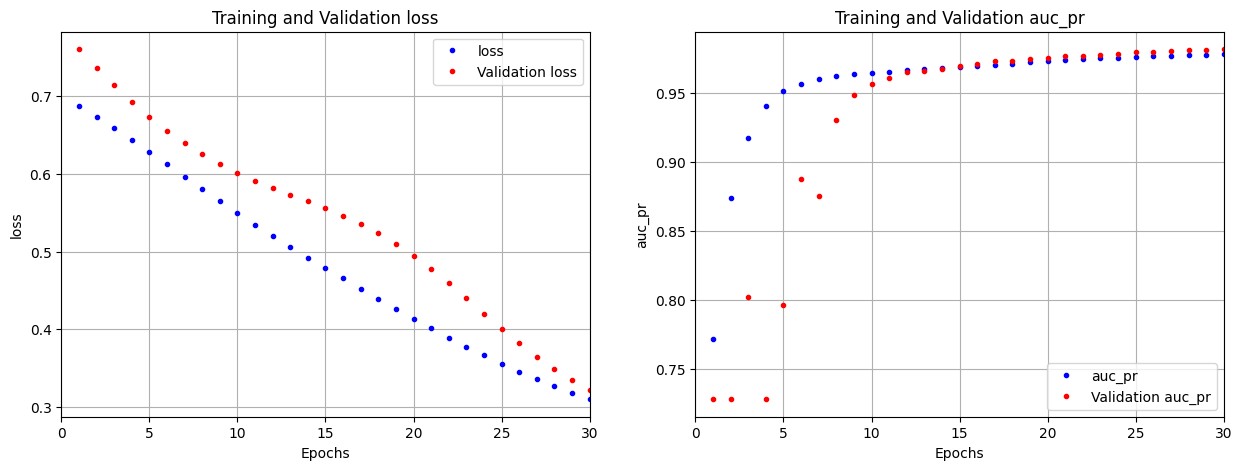

In [26]:
def plot_training_history(history, monitors=['loss', 'auc_pr']):
    fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15, 5))

    for ax, monitor in zip(axs.flat, monitors):
        loss, val_loss = history.history[monitor], 
        history.history['val_' + monitor]

        epochs = range(1, len(loss) + 1)

        ax.plot(epochs, loss, 'b.', label=monitor)
        ax.plot(epochs, val_loss, 'r.', 
                label='Validation ' + monitor)
        ax.set_xlim([0, len(loss)])
        ax.title.set_text('Training and Validation ' + monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
        ax.grid()

    plt.show()

plot_training_history(trained_simple_model['history'], 
                      monitors=['loss', 'auc_pr'])


From the plot above, the training loss starts relatively high (around 0.7) and decreases consistently and smoothly over the epochs, and eventually reaches a low value by the end of training (around 0.3). The decrease is smooth with no big variation, indicating the model is effectively learning from the training data and reducing the loss function value over time. Similarly, the validation loss also starts high and decreases throughout the training process. The validation loss curve is very close to the training loss curve, and no significant divergence is observed between the training and validation loss curves. This suggests that the model is not severely overfitting to the training data.

The training AUC-PR starts at a lower value, increases rapidly in the initial epochs and reaches a very high value (around 0.95) before continuing to increase slightly and plateau at around 0.98. This indicates the model's performance is improving quickly during training and rapidly reaches a high level. Similarly, the validation AUC-PR increases rapidly before plateauing. The performance of the validation AUC-PR curve is very close to the training AUC-PR curve, with no significant divergence, indicating consistent improvement and good generalisation in terms of AUC-PR.

## Developing a model that overfits

The next step in the DLWP 4.5 workflow (1st Edition) is to deliberately create an overfitting model. The intended output for this section would be for the model to perform exceptionally well on training data but fail to generalise to unseen data. Carrying out overfitting helps to visualise the risks of overfitting and lead to the next step where regularisation and hypertuning will be used to mitigate it and improve the model.

To induce overfitting, a deep neural network is defined with multiple hidden layers and a high number of neurons. The reLU activation is applied to the hidden layers to allow non-linear transformations and can help to create models with higher capacity which contributes to overfitting. The sigmoid activation is used in the output layer as the dataset is a binary classification. Batch normalisation is used as well to stabilise training and accelerate convergence.

In [27]:
def overfitting_neural_network(hidden_layers=3, hidden_neurons=512, 
                               activation='relu',
                               input_dimension=256, 
                               output_dimension=1,
                               optimizer=Adam(), 
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                                        tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
                                        tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'),
                                        F1Score()],
                               name='Overfitting_Model'):

    model = Sequential()
    model.add(Input(shape=(input_dimension,)))

    for _ in range(hidden_layers):
        model.add(Dense(hidden_neurons, activation=activation))
        model.add(BatchNormalization())

    model.add(Dense(output_dimension, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

The training data size is reduced, preventing the model from learning generalised patterns and allow it to memorise the data instead, encouraging overfitting.

In [28]:
X_train_small = X_train[:500]
y_train_small = y_train[:500]

The model parameters are futher defined here where the number of epochs have been increased to 50 to allow the model to fit the training data excessively and a smaller batch size of 16 is used to increase variance in weight update, making the model more sensitive to noise. A deeper architecture is used as well, with 3 hidden layers each with 128 neurons to increase model complexity.

In [29]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1
EPOCHS = 50
BATCH_SIZE = 16

In [30]:
overfit_model = overfitting_neural_network(hidden_layers=3, 
                                           hidden_neurons=128,
                                           activation='relu',
                                           input_dimension=INPUT_DIMENSION,
                                           output_dimension=OUTPUT_DIMENSION)

overfit_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,585 (264.00 KB)

 Trainable params: 66,817 (261.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [31]:
trained_overfit_model = train_deep_neural_network(overfit_model, 
                                            X_train_small, 
                                            y_train_small,
                                            batch_size=BATCH_SIZE, 
                                            epochs=EPOCHS,
                                            val_data=(X_val, y_val),
                                            callbacks=[], seed=SEED)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - auc_pr: 0.9646 - binary_accuracy: 0.8049 - f1_score: 0.8480 - loss: 0.4415 - precision: 0.9466 - recall: 0.7695 - val_auc_pr: 0.7280 - val_binary_accuracy: 0.7280 - val_f1_score: 0.8426 - val_loss: 0.6231 - val_precision: 0.7280 - val_recall: 1.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc_pr: 0.9929 - binary_accuracy: 0.9431 - f1_score: 0.9594 - loss: 0.1740 - precision: 0.9623 - recall: 0.9567 - val_auc_pr: 0.7384 - val_binary_accuracy: 0.7280 - val_f1_score: 0.8426 - val_loss: 0.5987 - val_precision: 0.7280 - val_recall: 1.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc_pr: 0.9975 - binary_accuracy: 0.9645 - f1_score: 0.9750 - loss: 0.1109 - precision: 0.9774 - recall: 0.9727 - val_auc_pr: 0.9017 - val_binary_accuracy: 0.7280 - val_f1_score: 0.8426 - val_loss: 0.5860 - val_precision: 0.7280 - val_recall: 1.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc_pr: 0.9988 - binary_accuracy: 0.9863 

In [34]:
print('Validation Accuracy: {:.2f} (baseline={:.2f})'.format(trained_overfit_model['val_score'][0], baseline))

print('Training Precision: {:.2f}'.format(trained_overfit_model['history'].history['precision'][-1]))
print('Training Recall: {:.2f}'.format(trained_overfit_model['history'].history['recall'][-1]))
print('Training F1-score: {:.2f}'.format(trained_overfit_model['history'].history['f1_score'][-1]))
print('Training AUC-PR: {:.2f}'.format(trained_overfit_model['history'].history['auc_pr'][-1]))

print('Validation Precision: {:.2f}'.format(trained_overfit_model['val_score'][4]))
print('Validation Recall: {:.2f}'.format(trained_overfit_model['val_score'][3]))
print('Validation F1-score: {:.2f}'.format(trained_overfit_model['val_score'][4]))
print('Validation AUC-PR: {:.2f}'.format(trained_overfit_model['val_score'][1]))

Validation Accuracy: 0.93 (baseline=0.73)
Training Precision: 1.00
Training Recall: 1.00
Training F1-score: 1.00
Training AUC-PR: 1.00
Validation Precision: 0.95
Validation Recall: 0.94
Validation F1-score: 0.95
Validation AUC-PR: 0.97


From the results, it can be seen that all the training metrics are at 1.00, which indicates that perfect scores of 100% have been achieved on the training set across all the metrics.
This suggests that the model has memorised the training data and has learned to perfectly classify every single example in the small training set, meaning that the model is overfitting as intended.

The validation metrics are all lower than the training metrics, which is a sign of overfitting where the model performs exceptionally well on the data it was trained on (training set) but the performance is slightly reduced when it encounters new, unseen data in the validation set. This shows that the model has a loss of generalisation ability as it is relying mostly on memorising.

Overall, the model is overfitting as intended.









.


.

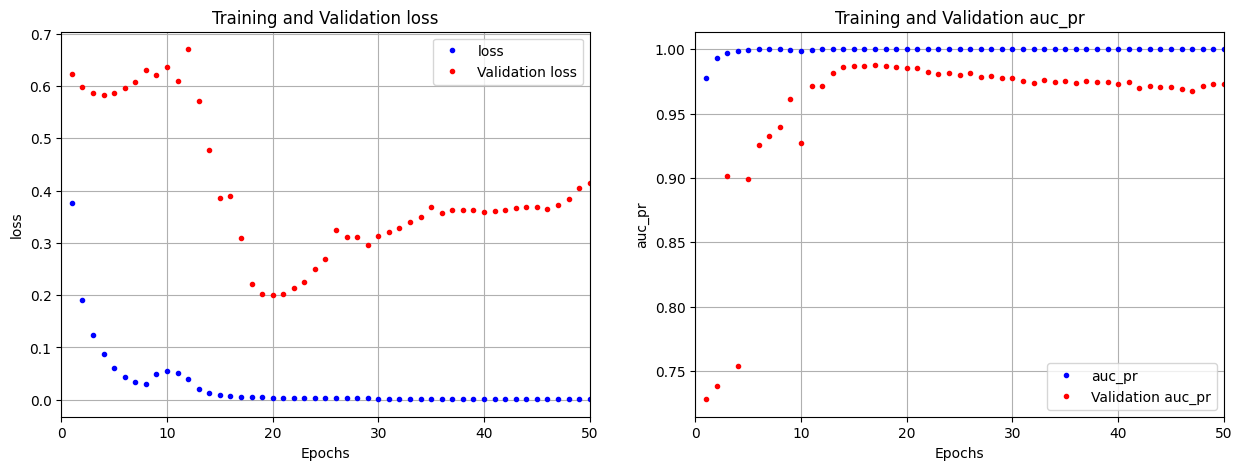

In [36]:
def plot_training_history(history, monitors=['loss', 'auc_pr']):
    fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15, 5))

    for ax, monitor in zip(axs.flat, monitors):
        loss, val_loss = history.history[monitor], 
        history.history['val_' + monitor]

        epochs = range(1, len(loss) + 1)

        ax.plot(epochs, loss, 'b.', label=monitor)
        ax.plot(epochs, val_loss, 'r.', 
                label='Validation ' + monitor)
        ax.set_xlim([0, len(loss)])
        ax.title.set_text('Training and Validation ' + monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
        ax.grid()

    plt.show()

plot_training_history(trained_overfit_model['history'], 
                      monitors=['loss', 'auc_pr'])

From the plot, it can be seen that the training loss starts at a relatively low value and drops rapidly to near zero within the first 10 epochs, and remains consistently very low for the rest of the training. The almost complete minimisation of training loss indicates that the model is fitting itself to the training data, hence it is overfitting. The validation loss initially decreases for the first few epochs, which could be due to the model learning some generalisable features.
However, after reaching a minimum point around epoch 8, the validation loss starts to increase and fluctuate upwards for the rest of the training, which could be due to the model no longer learning generalisable patterns and adapting to noise and specific details of the training set instead.

The training AUC-PR increases very rapidly and reaches near 1.0 within the first 10 epochs and then stays consistently very close to 1.0 for the remainder of the training. This is consistent with the numeric metrics obtained above. The validation AUC-PR increases initially and reaches a peak around epoch 10-15 before plateauing and fluctuating slightly downwards for the later epochs. The decrease in validation AUC-PR after an initial increase, while training AUC-PR remains perfect, shows that the model's ability to discriminate between classes in unseen data is declining, which indicates overfitting.




.




.

## Regularisation and hyperparameter tuning

The last step in the DLWP 4.5 workflow (1st Edition) would be to improve the generalisation performance of the deep neural network by carrying out regularisation and hyperparameter tuning.

In terms of regularisation, L2 regularisation (weight decay) has been carried out where a l2_value of 0.005 is added to the loss function to reduce the magnitude of weights, preventing excessive complexity in the model and overall preventing overfitting. A dropout value of 0.2 has been added as well to allow for random deactivation of a fraction of neurons during training to encourage robustness. Early stopping is also introduced here as patience (5) to monitor validation loss and halt training when no improvement is detected over a defined number of epochs.


In [50]:
def deep_neural_network(hidden_layers=2, hidden_neurons=128, 
                        activation='relu', dropout=0.2,
                        l2_value=0.005, input_dimension=256, 
                        output_dimension=1,
                        optimizer='adam', loss='binary_crossentropy',
                        metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                                 tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 F1Score()],
                        name=None):
    model = Sequential()

    model.add(Dense(hidden_neurons, activation=activation,
                    kernel_regularizer=
                    tf.keras.regularizers.l2(l2_value),
                    input_shape=(input_dimension,)))

    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_neurons, activation=activation,
                        kernel_regularizer=
                        tf.keras.regularizers.l2(l2_value)))
        model.add(Dropout(dropout))

    model.add(Dense(output_dimension, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

Stratified K-fold cross validation is used here as it ensures that the proportion of classes in each fold is maintained as it is in the original dataset. This is beneficial for the Pneumonia_MNIST dataset as it has inbalanced data, and using stratified K-fold cross validation will ensure that each fold will have roughly the same ratio of pneumonia-negative to penumonia-positive images, preventing one class from being over-represented or under-represented. The stratified K-fold cross validation works by splitting the training data into 5 subsets, where it performs training on four and validation on the remaining one. The model also iterates over all folds, ensuring performance is measured across different data distributions.









.


In [51]:
def train_deep_neural_network_cv(model, X, y, batch_size=128, 
                                 epochs=50, callbacks=[], 
                                 seed=0, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, 
                          random_state=seed)
    val_accuracies = []
    val_aucs_pr = []
    histories = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        history = model.fit(X_train_fold, y_train_fold,
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(X_val_fold, y_val_fold),
                            callbacks=callbacks,
                            verbose=0)

        val_score = model.evaluate(X_val_fold, y_val_fold, 
                                   verbose=0)[1:]
        val_accuracies.append(val_score[0])
        val_aucs_pr.append(val_score[1])
        histories.append(history)

    avg_val_accuracy = np.mean(val_accuracies)
    avg_val_auc_pr = np.mean(val_aucs_pr)

    return {'model': model,
            'val_accuracy_folds': val_accuracies,
            'val_auc_pr_folds': val_aucs_pr,
            'avg_val_accuracy': avg_val_accuracy,
            'avg_val_auc_pr': avg_val_auc_pr,
            'histories': histories}

In terms of hyperparameter tuning, a parameter grid has been used to explore different variations of the parameters of the model to find the best combination of parameters that could produce the model that performs the best. Each configuration of parameters is evaluated using all 5 folds of the stratified cross-validation.

In [52]:
param_grid = [
    {'hidden_layers': 1, 'hidden_neurons': 128, 'dropout': 0.1, 
     'l2_value': 0.0001, 'batch_size': 128, 'learning_rate': 0.0001},
    {'hidden_layers': 1, 'hidden_neurons': 256, 'dropout': 0.2, 
     'l2_value': 0.0005, 'batch_size': 128, 'learning_rate': 0.0005},
    {'hidden_layers': 2, 'hidden_neurons': 128, 'dropout': 0.2, 
     'l2_value': 0.0001, 'batch_size': 128, 'learning_rate': 0.0001},
    {'hidden_layers': 2, 'hidden_neurons': 256, 'dropout': 0.2, 
     'l2_value': 0.0005, 'batch_size': 128, 'learning_rate': 0.0001},
    {'hidden_layers': 2, 'hidden_neurons': 256, 'dropout': 0.3, 
     'l2_value': 0.0005, 'batch_size': 128, 'learning_rate': 0.0005},
    {'hidden_layers': 3, 'hidden_neurons': 128, 'dropout': 0.3, 
     'l2_value': 0.0001, 'batch_size': 128, 'learning_rate': 0.0005},
    {'hidden_layers': 3, 'hidden_neurons': 256, 'dropout': 0.4, 
     'l2_value': 0.0001, 'batch_size': 128, 'learning_rate': 0.0005},
    {'hidden_layers': 3, 'hidden_neurons': 256, 'dropout': 0.4, 
     'l2_value': 0.0005, 'batch_size': 128, 'learning_rate': 0.0005},
]

Varibles to store the architecture of the best model, the highest average validation accuracy achieved across all the hyperparameter configurations and the number of folds are initialised first. Then a loop is used to iterate through the different variations of architectures in the param_grid to build a new model is with each set of hyperparameters in the grid, before the models are trained and K-fold cross validation is carried out. The results are stored in an array for printing of results and the best model is detected using average validation accuracy.










.

In [53]:
best_model_cv = None
best_avg_val_acc_cv = 0
best_params_cv = None
results_cv = []
n_splits = 5

for params in param_grid:
    optimizer = tf.keras.optimizers.Adam(learning_rate=
                                         params['learning_rate'])
    model_cv = deep_neural_network(hidden_layers=
                                   params['hidden_layers'],
                                hidden_neurons=params['hidden_neurons'],
                                dropout=params['dropout'],
                                l2_value=params['l2_value'],
                                input_dimension=X_train.shape[1],
                                output_dimension=1,
                                optimizer=optimizer,
                                loss='binary_crossentropy',
                                metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                                         tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
                                         tf.keras.metrics.Precision(name='precision'),
                                         tf.keras.metrics.Recall(name='recall'),
                                         F1Score()])

    trained_model_cv = 
    train_deep_neural_network_cv(model_cv, X_train, y_train,
                                batch_size=params['batch_size'],
                                epochs=50,
                                callbacks=[EarlyStopping
                                           (monitor='val_loss', 
                                            patience=5, 
                                            restore_best_weights=True)],
                                seed=SEED,
                                n_splits=n_splits)

    avg_val_acc_cv = trained_model_cv['avg_val_accuracy']
    results_cv.append({
        'Hidden Layers': params['hidden_layers'],
        'Hidden Neurons': params['hidden_neurons'],
        'Dropout': params['dropout'],
        'L2 Value': params['l2_value'],
        'Batch Size': params['batch_size'],
        'Learning Rate': params['learning_rate'],
        'Average Validation Accuracy (CV)': avg_val_acc_cv,
        'Validation Accuracy Folds (CV)': trained_model_cv['val_accuracy_folds'],
        'Validation AUC-PR Folds (CV)': trained_model_cv['val_auc_pr_folds'],
    })

    if avg_val_acc_cv > best_avg_val_acc_cv:
        best_avg_val_acc_cv = avg_val_acc_cv
        best_model_cv = model_cv
        best_params_cv = params

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


Lastly, the results from the training above are printed to show how well each variation in the parameter grid performed and which is the best performing model. Holdout validation is carried out here to provide a final check on the best model chosen using K-fold cross-validation by training on the entire X_train, y_train dataset and evaluating on X_val, y_val dataset to ensure that it performs well on a held-out set. The holdout validation set is then used to generate the confusion matrix and classification report specifically for the best performing model.  



In [59]:
df_results_cv = pd.DataFrame(results_cv)

df_results_cv = df_results_cv.sort_values
(by='Average Validation Accuracy (CV)', ascending=False)

print("\n--- Cross-Validation Results ---")
print(df_results_cv.to_string(index=False))

print(f"\nBest Model Parameters (Cross-Validation): {best_params_cv}")
print(f"Best Average Validation Accuracy (Cross-Validation): {best_avg_val_acc_cv:.4f}")

print("\n--- Evaluation of Best Model on Hold-out Validation Set ---")
if best_model_cv is not None:
    best_model_val_score = best_model_cv.evaluate(X_val, y_val, verbose=0)
    print(f"Best Model Validation Loss: {best_model_val_score[0]:.4f}")
    print(f"Best Model Validation Accuracy: {best_model_val_score[1]:.4f}")
    print(f"Best Model Validation AUC-PR: {best_model_val_score[2]:.4f}")
    print(f"Best Model Validation Precision: {best_model_val_score[3]:.4f}")
    print(f"Best Model Validation Recall: {best_model_val_score[4]:.4f}")
    print(f"Best Model Validation F1-Score: {best_model_val_score[5]:.4f}")

    print("\n--- Confusion Matrix and Classification Report for Best Model ---")
    y_pred_proba_val_best = best_model_cv.predict(X_val)
    y_pred_binary_val_best = (y_pred_proba_val_best > 0.5).astype(int)

    conf_matrix_best = confusion_matrix(y_val, y_pred_binary_val_best)
    print("\nConfusion Matrix (Best Model - Validation Set):")
    print(conf_matrix_best)

    class_report_best = classification_report(y_val, y_pred_binary_val_best)
    print("\nClassification Report (Best Model - Validation Set):")
    print(class_report_best)
else:
    print("No best model found during cross-validation.")


--- Cross-Validation Results ---
 Hidden Layers  Hidden Neurons  Dropout  L2 Value  Batch Size  Learning Rate  Average Validation Accuracy (CV)                                                                       Validation Accuracy Folds (CV)                                                                         Validation AUC-PR Folds (CV)
             3             256      0.4    0.0001         128         0.0005                          0.936108 [0.9311859607696533, 0.9399707317352295, 0.9413489699363708, 0.9222874045372009, 0.9457477927207947] [0.9925781488418579, 0.9877878427505493, 0.9876512289047241, 0.9792830944061279, 0.9905833601951599]
             3             128      0.3    0.0001         128         0.0005                          0.933472  [0.9224011898040771, 0.9385066032409668, 0.936950147151947, 0.9252199530601501, 0.9442815184593201]  [0.991642951965332, 0.9874069690704346, 0.9886382818222046, 0.9795012474060059, 0.9904739260673523]
             3             

From the results, it can be seen that the top performing configuration of parameters would be the one with 3 hidden layers, 256 hidden neurons, 0.4 dropout, a batch size of 128, an L2 value of 0.0001 and a learning rate of 0.0005 with the highest average validation accuracy of 0.9361 in cross-validation.

The validation accuracy and AUC-PR values were relatively consistent across the 5 folds, ranging from approximately 0.922 to 0.946. This suggests that the performance estimate from cross-validation is robust and not highly dependent on a specific data split.

The hold-out validation carried out on the best model also achieved high results where the validation accuracy is 0.9297, validation AUC-PR is 0.9911, validation precision is 0.9335, validation recall is 0.9726, and
validation F1-score is 0.9527, suggesteing that the model is performing accurately.
The validation accuracy of 0.9297 on the hold-out set is very close to the average validation accuracy from cross-validation 0.9361, showing that cross-validation estimate is high robust.

From the confusion matrix, it can be seen that the true negatives is 189, indicating that the model correctly predicted 189 cases as pneumonia-negative and the true positives is 604, indicating that the model model correctly predicted 604 cases as pneumonia-positive. The number of false negatives is 17 and the number of false positives is 43. The number of false negatives is low, indicating that the model is good at identifying actual pneumonia cases, and this is  also reflected in the high recall score of 0.9726. The number of false positives is higher than false negatives, suggesting that the model is more prone to incorrectly diagnosing pneumonia-positive when it is not actually present.

In the classification report, it is shown for class 1 (pneumonia-postive) that the model predicts pneumonia-postive correctly 93% of the time, which is a good precision for the positive class. The model correctly  identifies 97% out of all the pneumonia-postive cases, which shows that the model is excellent at detecting pneumonia-positive cases and minimising false negatives. The F1-score of 95% is also high, indicating a strong balance between precision and recall for the pneumonia-postive class. For class 0 (pneumonia-negative), it is seen that the model predicts pneumonia-negative correctly 92% of the time, which is a good precision for the negative class. The model correctly identifies 81% out of all the pneumonia-negative cases, which is lower than class 1, meaning the model misses a larger proportion of pneumonia-negative cases, resulting in False Positives for Pneumonia class. The F1-score of 86% indicates a relatively high balance between precision and recall, but lower than class 1.
The model has an overall accuracy of 93%, which is consistent with the validation accuracy reported earlier.


Overall, the best model identified through cross-validation performed well on the hold-out validation set as well, achieving a high accuracy of around 93% and very high AUC-PR of 0.9911, strong precision and recall, and a good F1-score. The model displays a strong overall classification performance, with high sensitivity and effectiveness at detecting pneumonia cases while minimising false negatives, which is crucial in a medical context. The high precision and reacll shows a reasonable balance and not an excessive number of false positives. The model is also able to generalise well.
A potential weakness detected in the model is that there are more false positives than false negatives. In a actual medical diagnosis context,although minimising false negatives is often prioritised, reducing false positives is also important to avoid unnecessary interventions and anxiety.
Nevertheless, the chosen model remains the best choice based on the cross-validation and hold-out validation results, including the detailed classification report as it provides a strong balance of performance, especially in terms of accurately detecting pneumonia-positive cases.

